In [42]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.stats import skew, kurtosis
import matplotlib.dates as mdates


import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.gnn import create_features, create_label
from spektral.layers import GCNConv
from spektral.utils import gcn_filter
from sklearn.preprocessing import StandardScaler
from shared.helpers import store_predictions_and_create_graph

In [43]:
file_path = "../data/parsed_dataset.csv"
date_column = "period"
target_column = "value"
id_column = "parent"
df = pd.read_csv(file_path)[[date_column, target_column, id_column]]
df[date_column] = pd.to_datetime(df[date_column])
df = df.groupby([date_column, id_column])[target_column].sum().reset_index()
unique_dates = df[date_column].unique()
um_countries_regions = len(df[id_column].unique())
df.head()

,period,parent,value
0,2023-01-02 06:00:00,CISO,24640
1,2023-01-02 06:00:00,ERCO,37574
2,2023-01-02 06:00:00,ISNE,10377
3,2023-01-02 06:00:00,MISO,59560
4,2023-01-02 06:00:00,NYIS,14054


In [44]:
scaler = StandardScaler()
unscaled_data = df.groupby(date_column).sum().reset_index()
scaled_data = scaler.fit_transform(df[[target_column]])
df[target_column] = scaled_data

In [45]:
# pivot_df = df.pivot_table(index=date_column, columns=id_column, values=target_column)

df.rename(columns={"index": date_column}, inplace=True)
df.head()


,period,parent,value
0,2023-01-02 06:00:00,CISO,-0.416873
1,2023-01-02 06:00:00,ERCO,0.018846
2,2023-01-02 06:00:00,ISNE,-0.897364
3,2023-01-02 06:00:00,MISO,0.759508
4,2023-01-02 06:00:00,NYIS,-0.773493


In [46]:
unstaked_df = df.copy()
unstaked_df["id"] = unstaked_df[id_column]
unstaked_df.set_index(["id", date_column], inplace=True)

# Dropping columns not needed for the analysis
unstaked_df.drop([id_column], axis=1, inplace=True)

# Converting data to float and unstacking
unstaked_df = unstaked_df.astype(float).unstack()
unstaked_df.columns = unstaked_df.columns.get_level_values(1)

# Displaying the shape and head of the updated DataFrame
print(unstaked_df.shape)
unstaked_df.iloc[:, :15].head()

(8, 11467)


period,2023-01-02 06:00:00,2023-01-02 07:00:00,2023-01-02 08:00:00,2023-01-02 09:00:00,2023-01-02 10:00:00,2023-01-02 11:00:00,2023-01-02 12:00:00,2023-01-02 13:00:00,2023-01-02 14:00:00,2023-01-02 15:00:00,2023-01-02 16:00:00,2023-01-02 17:00:00,2023-01-02 18:00:00,2023-01-02 19:00:00,2023-01-02 20:00:00
id,,,,,,,,,,,,,,,
CISO,-0.416873,-0.429675,-0.464979,-0.509279,-0.523226,-0.547043,-0.562034,-0.561866,-0.555398,-0.523697,-0.481823,-0.468786,-0.473031,-0.460432,-0.456120
ERCO,0.018846,-0.031989,-0.065711,-0.089292,-0.100881,-0.094615,-0.070124,-0.029732,0.007426,0.038149,0.099427,0.143087,0.187285,0.214000,0.231855
ISNE,-0.897364,-0.906628,-0.910300,-0.909087,-0.901137,-0.884326,-0.860071,-0.840094,-0.822812,-0.809371,-0.802701,-0.800949,-0.802869,-0.802162,-0.801791
MISO,0.759508,0.699880,0.662318,0.646418,0.645912,0.677310,0.735792,0.818058,0.883109,0.937953,1.009270,1.051784,1.079206,1.087898,1.088133
NYIS,-0.773493,-0.787507,-0.796502,-0.798894,-0.795525,-0.783296,-0.762376,-0.740782,-0.720839,-0.706724,-0.701266,-0.703557,-0.703018,-0.705612,-0.700323


In [47]:
sequence_length = 24

In [48]:
### DEFINE TRAIN, VALID, TEST DATES ###

train_date = unique_dates[0]
valid_date = unique_dates[int(len(unique_dates) *0.8)+1]
test_date = unique_dates[int(len(unique_dates) *0.9)]

In [49]:
unstaked_df.columns

DatetimeIndex(['2023-01-02 06:00:00', '2023-01-02 07:00:00',
               '2023-01-02 08:00:00', '2023-01-02 09:00:00',
               '2023-01-02 10:00:00', '2023-01-02 11:00:00',
               '2023-01-02 12:00:00', '2023-01-02 13:00:00',
               '2023-01-02 14:00:00', '2023-01-02 15:00:00',
               ...
               '2024-04-23 15:00:00', '2024-04-23 16:00:00',
               '2024-04-23 17:00:00', '2024-04-23 18:00:00',
               '2024-04-23 19:00:00', '2024-04-23 20:00:00',
               '2024-04-23 21:00:00', '2024-04-23 22:00:00',
               '2024-04-23 23:00:00', '2024-04-24 00:00:00'],
              dtype='datetime64[ns]', name='period', length=11467, freq=None)

In [50]:
X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(train_date + timedelta(hours=sequence_length), valid_date, freq="H")):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length, um_countries_regions, "H")
    y_ = create_label(unstaked_df, d, um_countries_regions)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_train_seq = np.concatenate(X_seq, axis=0).astype("float32")
X_train_cor = np.concatenate(X_cor, axis=0).astype("float32")
X_train_feat = np.concatenate(X_feat, axis=0).astype("float32")
y_train = np.concatenate(y, axis=0).astype("float32")

print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, y_train.shape)

  0%|          | 0/9151 [00:00<?, ?it/s]

100%|██████████| 9151/9151 [00:28<00:00, 318.03it/s]

(9151, 24, 8) (9151, 8, 8) (9151, 8, 7) (9151, 8)


In [51]:
X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(valid_date + timedelta(hours=sequence_length), test_date, freq="H")):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length, um_countries_regions, "H")
    y_ = create_label(unstaked_df, d, um_countries_regions)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_valid_seq = np.concatenate(X_seq, axis=0).astype("float32")
X_valid_cor = np.concatenate(X_cor, axis=0).astype("float32")
X_valid_feat = np.concatenate(X_feat, axis=0).astype("float32")
y_valid = np.concatenate(y, axis=0).astype("float32")

print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, y_valid.shape)

100%|██████████| 1123/1123 [00:03<00:00, 346.04it/s]

(1123, 24, 8) (1123, 8, 8) (1123, 8, 7) (1123, 8)


In [52]:
X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(
    pd.date_range(test_date + timedelta(hours=sequence_length), unique_dates[-1], freq="H")
):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length, um_countries_regions, "H")
    y_ = create_label(unstaked_df, d, um_countries_regions)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_test_seq = np.concatenate(X_seq, axis=0).astype("float32")
X_test_cor = np.concatenate(X_cor, axis=0).astype("float32")
X_test_feat = np.concatenate(X_feat, axis=0).astype("float32")
y_test = np.concatenate(y, axis=0).astype("float32")

print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)

100%|██████████| 1123/1123 [00:03<00:00, 348.89it/s]


(1123, 24, 8) (1123, 8, 8) (1123, 8, 7) (1123, 8)


In [53]:
X_train_lap = gcn_filter(1 - np.abs(X_train_cor))
X_valid_lap = gcn_filter(1 - np.abs(X_valid_cor))
X_test_lap = gcn_filter(1 - np.abs(X_test_cor))

In [54]:
pred_test_all = np.zeros(y_test.shape)
models = []
model_files = []
from keras.callbacks import Callback

class DebuggingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        pred = self.model.predict([X_valid_seq, X_valid_lap, X_valid_feat])
        print(f"Epoch {epoch}: sample predictions {pred[:5]}")
for region in range(um_countries_regions):
    print("-------", "region", region, "-------")

    es = EarlyStopping(
        patience=5,
        verbose=1,
        min_delta=0.1,  # More sensitive change detection
        monitor="val_loss",
        mode="auto",
        restore_best_weights=True
    )

    inp_seq = Input((sequence_length, um_countries_regions))
    inp_lap = Input((um_countries_regions, um_countries_regions))
    inp_feat = Input((um_countries_regions, X_train_feat.shape[-1]))

    x = GCNConv(128, activation="relu")([inp_feat, inp_lap])
    x = GCNConv(64, activation="relu")([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(128, activation="relu", return_sequences=True)(inp_seq)
    xx = LSTM(64, activation="relu")(xx)
    

    x = Concatenate()([x, xx])
    x = Dropout(0.5)(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Reduced learning rate
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    model.fit(
        [X_train_seq, X_train_lap, X_train_feat],
        y_train[:, region],
        epochs=1000,
        batch_size=16,
        validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], y_test[:, region]),
        callbacks=[es, DebuggingCallback()],
        verbose=1
    )
    model.save(f"../stored_models/gnn/gnn_{region}.h5")
    model_files.append(f"gnn_{region}")
    models.append(model)


------- region 0 -------
Epoch 1/1000
36/36 [==============================] - 1s 8ms/step loss: 0.0211 - root_mean_squared_er
Epoch 0: sample predictions [[-0.3606469 ]
 [-0.36290234]
 [-0.36313367]
 [-0.36159658]
 [-0.35798603]]
572/572 [==============================] - 13s 18ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1314
Epoch 2/1000
36/36 [==============================] - 0s 7ms/step loss: 0.0131 - root_mean_squared_err
Epoch 1: sample predictions [[-0.4314527 ]
 [-0.43123984]
 [-0.4313298 ]
 [-0.43062764]
 [-0.4303056 ]]
572/572 [==============================] - 10s 17ms/step - loss: 0.0131 - root_mean_squared_error: 0.1146 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1111
Epoch 3/1000
36/36 [==============================] - 0s 7ms/step loss: 0.0097 - root_mean_squared_err
Epoch 2: sample predictions [[-0.4808485 ]
 [-0.48172122]
 [-0.48086333]
 [-0.47115222]
 [-0.45304537]]
572/572 [====================

/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/1000
36/36 [==============================] - 1s 8ms/step loss: 0.0635 - root_mean_squared_er
Epoch 0: sample predictions [[0.7199868 ]
 [0.76894855]
 [0.814081  ]
 [0.85255766]
 [0.8819213 ]]
572/572 [==============================] - 14s 19ms/step - loss: 0.0635 - root_mean_squared_error: 0.2520 - val_loss: 0.0629 - val_root_mean_squared_error: 0.2507
Epoch 2/1000
36/36 [==============================] - 0s 7ms/step loss: 0.0328 - root_mean_squared_err
Epoch 1: sample predictions [[0.75354815]
 [0.8102927 ]
 [0.85843444]
 [0.8943591 ]
 [0.91757965]]
572/572 [==============================] - 10s 17ms/step - loss: 0.0327 - root_mean_squared_error: 0.1809 - val_loss: 0.0570 - val_root_mean_squared_error: 0.2387
Epoch 3/1000
36/36 [==============================] - 0s 8ms/step loss: 0.0267 - root_mean_squared_e
Epoch 2: sample predictions [[0.8364797 ]
 [0.8869278 ]
 [0.9291465 ]
 [0.9491088 ]
 [0.95781785]]
572/572 [==============================] - 10s 18ms/step - loss: 0.0267

In [55]:
for region, model in enumerate(models):
    pred_test_all[:, region] = scaler.inverse_transform(model.predict(
        [X_test_seq, X_test_lap, X_test_feat]
    )).ravel()

36/36 [==============================] - 0s 8ms/step


In [56]:
y_true = np.sum(scaler.inverse_transform(y_test), axis=1)
pred = np.sum(pred_test_all, axis=1)
unscaled_y_train = unscaled_data.iloc[-y_true.shape[0]:]['value']

In [57]:
unscaled_y_train

10344    262375
10345    254990
10346    250403
10347    247814
10348    250116
          ...  
11462    262859
11463    264561
11464    268273
11465    270369
11466    272406
Name: value, Length: 1123, dtype: int64

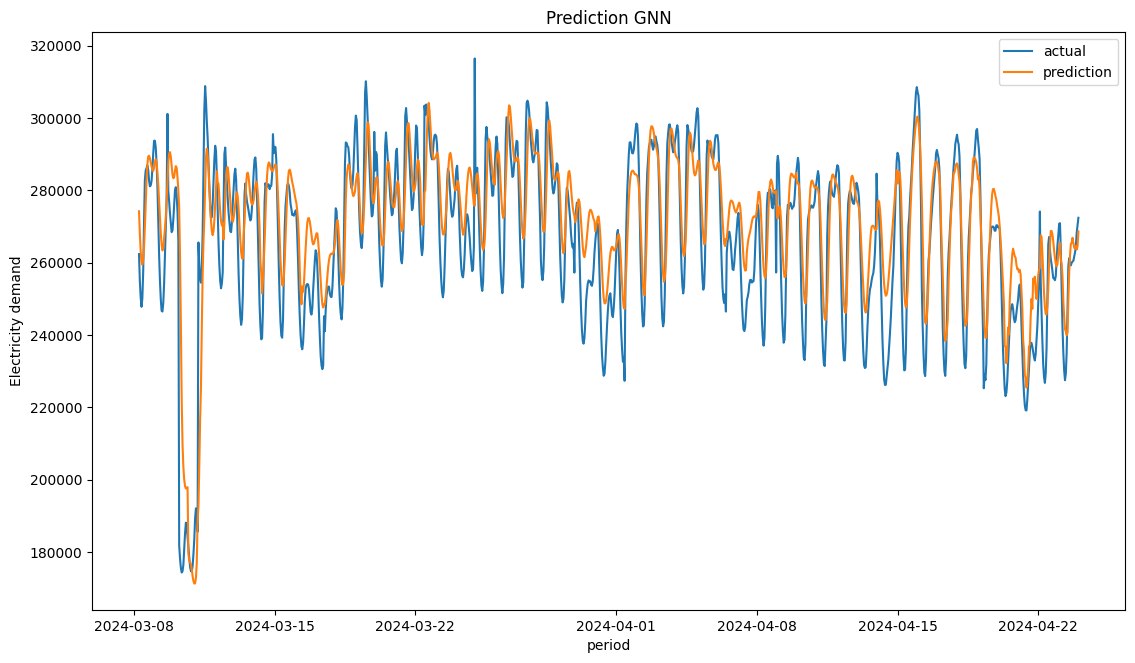

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(unique_dates[-len(pred):], y_true-1, label="actual")
ax.plot(unique_dates[-len(pred):], pred-1, label="prediction")
ax.set_title("Prediction GNN")
ax.set_ylabel("Electricity demand")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [59]:
print_evaluation_metrics(pred-1, y_true-1, unscaled_y_train -1)

Evaluation Metrics:
MSE: 158859041.48
RMSE: 12603.93
MAE: 9789.00
MAPE: 3.83
SMAPE: 3.75
MASE: 2.00


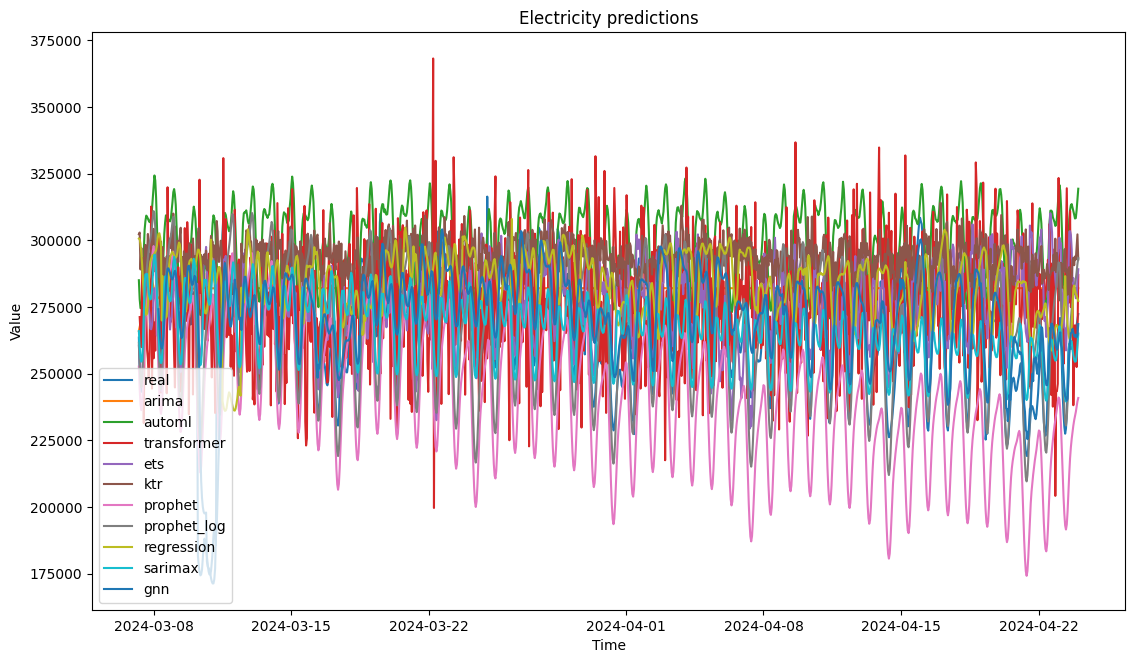

In [60]:
store_predictions_and_create_graph("gnn", unique_dates[-len(pred):], pred-1, y_true-1, "Electricity")